## Learning Rate Setting

In [31]:
import torch 
import torchvision.models as models

from torch import optim
from matplotlib import pyplot as plt

In [70]:
model = models.resnet18()
optimizer = optim.SGD(params = model.parameters(), lr=0.001)

### 1.不设置, 保持学习率不变

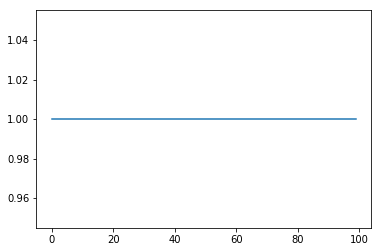

In [6]:
plt.figure()
x = list()
y = list()
for epoch in range(100):
    x.append(epoch)
    y.append(scheduler.get_lr()[0])
plt.plot(x,y)

### ２.阶梯下降方式

In [7]:
##### (1)　公式 

In [8]:
# Assuming optimizer uses lr = 1.0 for all groups
# lr = 1.0     if epoch < 30
# lr = 0.1    if 30 <= epoch < 60
# lr = 0.01   if 60 <= epoch < 90
# ...

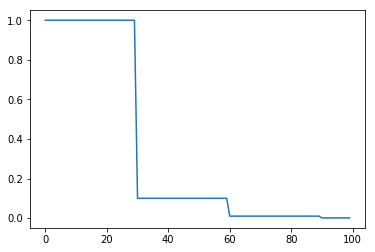

In [9]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

plt.figure()
x = list()
y = list()
for epoch in range(100):
    x.append(epoch)
    y.append(scheduler.get_lr()[0])
    scheduler.step()
plt.plot(x,y)

In [10]:
##### (2)　公式

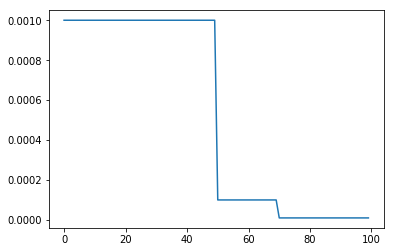

In [11]:
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 70], gamma=0.1)

plt.figure()
x = list()
y = list()
for epoch in range(100):
    x.append(epoch)
    y.append(scheduler.get_lr()[0])
    scheduler.step()
plt.plot(x,y)

In [12]:
##### (3)　公式

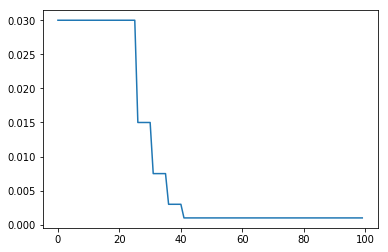

In [13]:
def adjust_learning_rate(optimizer, epoch):
    """ """
    lr = 30e-3
    if epoch > 25:
        lr = 15e-3
    if epoch > 30:
        lr = 7.5e-3
    if epoch > 35:
        lr = 3e-3
    if epoch > 40:
        lr = 1e-3
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

plt.figure()
x = list()
y = list()
for epoch in range(100):
    adjust_learning_rate(optimizer, epoch)
    x.append(epoch)
    y.append(scheduler.get_lr()[0])
plt.plot(x,y) 

### 3.　指数方式

In [14]:
# lr=lr∗gamma∗∗epoch

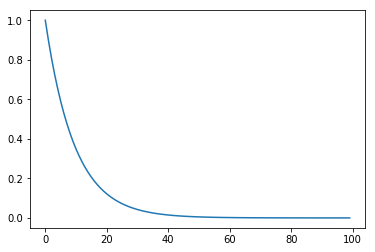

In [15]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1)

plt.figure()
x = list()
y = list()
for epoch in range(100):
    x.append(epoch)
    y.append(scheduler.get_lr()[0])
    scheduler.step()
plt.plot(x,y)

### 4.循环模式

In [16]:
###　余弦退火

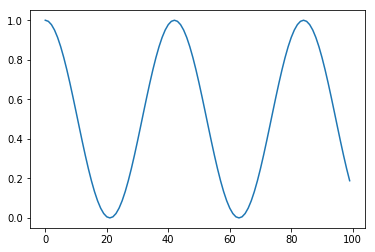

In [17]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = (100 // 5) + 1)

plt.figure()
x = list()
y = list()
for epoch in range(100):
    x.append(epoch)
    y.append(scheduler.get_lr()[0])
    scheduler.step()
plt.plot(x,y)

In [18]:
### CyclicLR

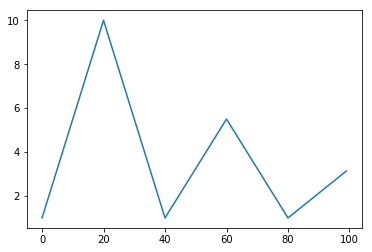

In [19]:
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                              base_lr=0.1,  max_lr=10, 
                                              step_size_up=20, step_size_down=None, 
                                              mode='triangular2', gamma=0.1, 
                                              scale_fn=None, scale_mode='cycle',
                                              cycle_momentum=True, base_momentum=0.8,
                                              max_momentum=0.9, last_epoch=-1)

plt.figure()
x = list()
y = list()
for epoch in range(100):
    x.append(epoch)
    y.append(scheduler.get_lr()[0])
    scheduler.step()
plt.plot(x,y)

In [27]:
### CosineAnnealingWarmRestarts

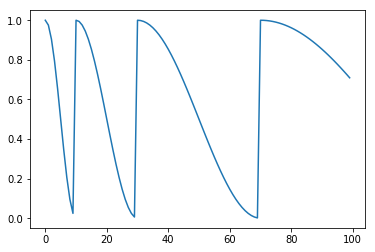

In [29]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=10,T_mult=2,eta_min=0)

plt.figure()
x = []
y = []
for epoch in range(100):
    scheduler.step()
    x.append(epoch)
    y.append(scheduler.get_lr()[0])
plt.plot(x, y)

### 5. 自适应调整学习率 ReduceLROnPlateau

In [ ]:
# Reduce learning rate when validation accuarcy plateau.\
# 当某指标不再变化（下降或升高），调整学习率，这是非常实用的学习率调整策略。
# 例如，当验证集的 loss 不再下降时，进行学习率调整；或者监测验证集的 accuracy，当accuracy 不再上升时，则调整学习率。
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)


for t in range(0, 80):
    train(...);
    val(...)
    scheduler.step(val_acc)

### 6. Lambda 算子

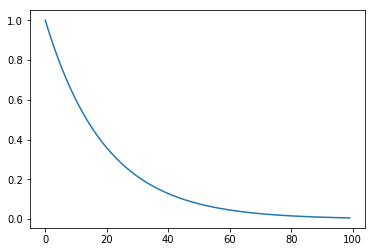

In [24]:
# Learning rate warmup by 10 epochs.
lambda1 = lambda epoch: 0.95 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

plt.figure()
x = list()
y = list()
for epoch in range(100):
    x.append(epoch)
    y.append(optimizer.param_groups[0]['lr'])
    scheduler.step()
plt.plot(x,y)

### 7. Warmup 

In [76]:
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau


class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier
        warmup_epoch: target learning rate is reached at warmup_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """

    def __init__(self, optimizer, multiplier, warmup_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier <= 1.:
            raise ValueError('multiplier should be greater than 1.')
        self.warmup_epoch = warmup_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.warmup_epoch + 1.) for base_lr in self.base_lrs]

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.warmup_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.warmup_epoch)
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)

In [88]:
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 500)
scheduler = GradualWarmupScheduler(optimizer, multiplier=8, warmup_epoch=10, after_scheduler=scheduler_cosine)

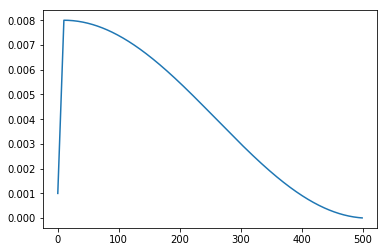

In [89]:
plt.figure()
x = list()
y = list()
for epoch in range(500):
    x.append(epoch)
    y.append(scheduler.get_lr()[0])
    scheduler.step() 
plt.plot(x,y)

### 8. 对不同层设置不同的学习率

In [ ]:
conv5_params = list(map(id, net.conv5.parameters()))
conv4_params = list(map(id, net.conv4.parameters()))
base_params = filter(lambda p: id(p) not in conv5_params + conv4_params,
                     net.parameters())

optimizer = torch.optim.SGD([
            {'params': base_params},
            {'params': net.conv5.parameters(), 'lr': lr * 100},
            {'params': net.conv4.parameters(), 'lr': lr * 100}],
            , lr=lr, momentum=0.9)